In [1]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Загрузка MNIST dataset
train_dataset = MNIST(root="./data", train=True, download=True, transform=ToTensor())
test_dataset = MNIST(root="./data", train=False, download=True, transform=ToTensor())


100%|██████████| 9912422/9912422 [00:14<00:00, 664111.05it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 1129028.20it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:03<00:00, 538392.89it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [2]:
# Определение модели нейронной сети
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 10)
        self.bn1 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Создание экземпляра модели
model = MNISTClassifier()

# Отображение summary модели
print(model)


MNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [3]:
# Определение функций потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучающая функция
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    return train_loss

# Тестовая функция
def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    all_preds = []
    true_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item() * data.size(0)
            _, preds = torch.max(output, 1)
            correct_preds += torch.sum(preds == target)
            all_preds.extend(preds.tolist())
            true_labels.extend(target.tolist())
    test_loss = running_loss / len(test_loader.dataset)
    accuracy = correct_preds.double() / len(test_loader.dataset)
    precision = precision_score(true_labels, all_preds, average="macro")
    recall = recall_score(true_labels, all_preds, average="macro")
    f1 = f1_score(true_labels, all_preds, average="macro")
    return test_loss, accuracy, precision, recall, f1


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:13<00:00, 19.39s/it]


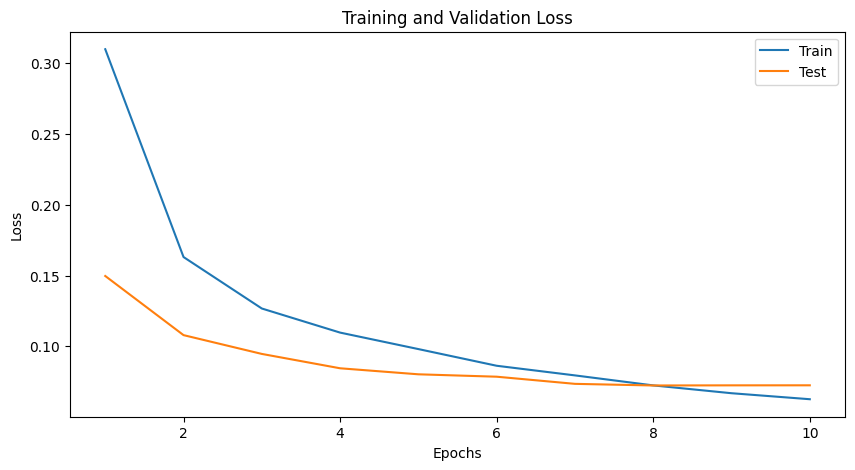

            Test Loss                             Accuracy  Precision   
Experiment                                                              
1            0.149702  tensor(0.9573, dtype=torch.float64)   0.956972  \
2            0.107931  tensor(0.9686, dtype=torch.float64)   0.968769   
3            0.094656  tensor(0.9723, dtype=torch.float64)   0.972221   
4            0.084510  tensor(0.9745, dtype=torch.float64)   0.974438   
5            0.080257  tensor(0.9760, dtype=torch.float64)   0.975935   
6            0.078563  tensor(0.9762, dtype=torch.float64)   0.976309   
7            0.073512  tensor(0.9771, dtype=torch.float64)   0.977056   
8            0.072364  tensor(0.9776, dtype=torch.float64)   0.977525   
9            0.072458  tensor(0.9784, dtype=torch.float64)   0.978360   
10           0.072485  tensor(0.9780, dtype=torch.float64)   0.978046   

              Recall  F1 Score  
Experiment                      
1           0.956898  0.956838  
2           0.968388  0.

In [4]:
# Обучение модели
NUM_EPOCHS = 10
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_losses = []
test_losses = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for epoch in tqdm(range(NUM_EPOCHS)):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss, accuracy, precision, recall, f1 = test(model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label="Train")
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Вывод результатов
results_table = {
    "Experiment": list(range(1, NUM_EPOCHS + 1)),
    "Test Loss": test_losses,
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores,
}

import pandas as pd

results_df = pd.DataFrame(results_table)
results_df.set_index("Experiment", inplace=True)
print(results_df)


# Эксперимент с использованием сверточных слоев.
# Эксперимент с увеличением числа слоев и добавлением Dropout и BatchNorm.

In [5]:
# Эксперимент 1: Использование сверточных слоев

class CNNMNISTClassifier(nn.Module):
    def __init__(self):
        super(CNNMNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Создание экземпляра модели
cnn_model = CNNMNISTClassifier()

# Отображение summary модели
print(cnn_model)


CNNMNISTClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [19:39<00:00, 117.95s/it]


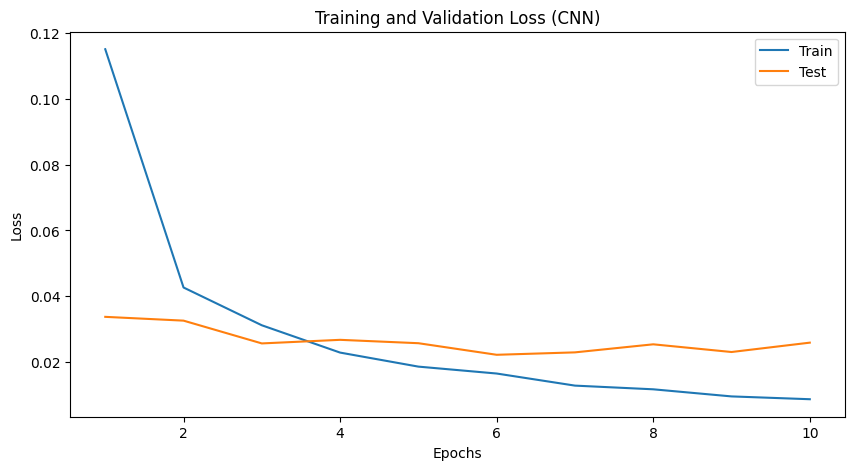

            Test Loss                             Accuracy  Precision   
Experiment                                                              
1            0.033713  tensor(0.9899, dtype=torch.float64)   0.989970  \
2            0.032559  tensor(0.9894, dtype=torch.float64)   0.989251   
3            0.025625  tensor(0.9921, dtype=torch.float64)   0.992140   
4            0.026717  tensor(0.9904, dtype=torch.float64)   0.990357   
5            0.025690  tensor(0.9927, dtype=torch.float64)   0.992714   
6            0.022164  tensor(0.9929, dtype=torch.float64)   0.992884   
7            0.022901  tensor(0.9926, dtype=torch.float64)   0.992543   
8            0.025352  tensor(0.9927, dtype=torch.float64)   0.992766   
9            0.023011  tensor(0.9928, dtype=torch.float64)   0.992878   
10           0.025860  tensor(0.9917, dtype=torch.float64)   0.991743   

              Recall  F1 Score  
Experiment                      
1           0.989690  0.989816  
2           0.989259  0.

In [6]:
# Обучение сверточной модели

cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

cnn_train_losses = []
cnn_test_losses = []
cnn_accuracy_scores = []
cnn_precision_scores = []
cnn_recall_scores = []
cnn_f1_scores = []

for epoch in tqdm(range(NUM_EPOCHS)):
    cnn_train_loss = train(cnn_model, train_loader, cnn_optimizer, criterion)
    cnn_test_loss, cnn_accuracy, cnn_precision, cnn_recall, cnn_f1 = test(cnn_model, test_loader, criterion)
    cnn_train_losses.append(cnn_train_loss)
    cnn_test_losses.append(cnn_test_loss)
    cnn_accuracy_scores.append(cnn_accuracy)
    cnn_precision_scores.append(cnn_precision)
    cnn_recall_scores.append(cnn_recall)
    cnn_f1_scores.append(cnn_f1)

# Построение графика для сверточной модели
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), cnn_train_losses, label="Train")
plt.plot(range(1, NUM_EPOCHS + 1), cnn_test_losses, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (CNN)")
plt.legend()
plt.show()

# Вывод результатов для сверточной модели
cnn_results_table = {
    "Experiment": list(range(1, NUM_EPOCHS + 1)),
    "Test Loss": cnn_test_losses,
    "Accuracy": cnn_accuracy_scores,
    "Precision": cnn_precision_scores,
    "Recall": cnn_recall_scores,
    "F1 Score": cnn_f1_scores,
}

cnn_results_df = pd.DataFrame(cnn_results_table)
cnn_results_df.set_index("Experiment", inplace=True)
print(cnn_results_df)


In [12]:
# Эксперимент 2: Увеличение числа слоев и добавление Dropout и BatchNorm

class DeepMNISTClassifier(nn.Module):
    def __init__(self):
        super(DeepMNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

# Создание экземпляра модели
deep_model = DeepMNISTClassifier()

# Отображение summary модели
print(deep_model)


DeepMNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


100%|██████████| 10/10 [04:21<00:00, 26.18s/it]


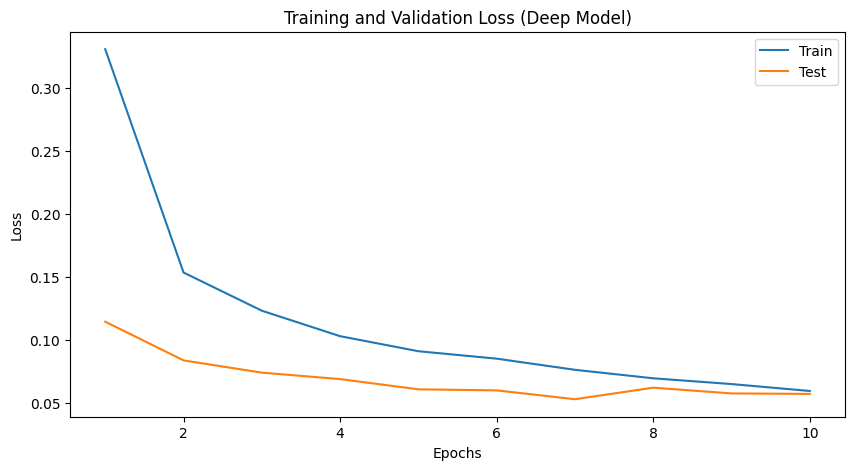

            Test Loss                             Accuracy  Precision   
Experiment                                                              
1            0.114469  tensor(0.9648, dtype=torch.float64)   0.964495  \
2            0.083733  tensor(0.9733, dtype=torch.float64)   0.973145   
3            0.073988  tensor(0.9760, dtype=torch.float64)   0.976032   
4            0.068865  tensor(0.9800, dtype=torch.float64)   0.980013   
5            0.060740  tensor(0.9812, dtype=torch.float64)   0.981012   
6            0.059899  tensor(0.9809, dtype=torch.float64)   0.981060   
7            0.052870  tensor(0.9830, dtype=torch.float64)   0.982932   
8            0.062035  tensor(0.9814, dtype=torch.float64)   0.981257   
9            0.057478  tensor(0.9819, dtype=torch.float64)   0.981971   
10           0.057085  tensor(0.9832, dtype=torch.float64)   0.983198   

              Recall  F1 Score  
Experiment                      
1           0.964347  0.964306  
2           0.973218  0.

In [13]:
# Обучение модели с увеличенным числом слоев и Dropout и BatchNorm

deep_optimizer = optim.Adam(deep_model.parameters(), lr=0.001)

deep_train_losses = []
deep_test_losses = []
deep_accuracy_scores = []
deep_precision_scores = []
deep_recall_scores = []
deep_f1_scores = []

for epoch in tqdm(range(NUM_EPOCHS)):
    deep_train_loss = train(deep_model, train_loader, deep_optimizer, criterion)
    deep_test_loss, deep_accuracy, deep_precision, deep_recall, deep_f1 = test(deep_model, test_loader, criterion)
    deep_train_losses.append(deep_train_loss)
    deep_test_losses.append(deep_test_loss)
    deep_accuracy_scores.append(deep_accuracy)
    deep_precision_scores.append(deep_precision)
    deep_recall_scores.append(deep_recall)
    deep_f1_scores.append(deep_f1)

# Построение графика для модели с увеличенным числом слоев
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), deep_train_losses, label="Train")
plt.plot(range(1, NUM_EPOCHS + 1), deep_test_losses, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (Deep Model)")
plt.legend()
plt.show()

deep_results_table = {
    "Experiment": list(range(1, NUM_EPOCHS + 1)),
    "Test Loss": deep_test_losses,
    "Accuracy": deep_accuracy_scores,
    "Precision": deep_precision_scores,
    "Recall": deep_recall_scores,
    "F1 Score": deep_f1_scores,
}

deep_results_df = pd.DataFrame(deep_results_table)
deep_results_df.set_index("Experiment", inplace=True)
print(deep_results_df)


## Первая модель:

In [14]:
print(cnn_results_df)

            Test Loss                             Accuracy  Precision   
Experiment                                                              
1            0.033713  tensor(0.9899, dtype=torch.float64)   0.989970  \
2            0.032559  tensor(0.9894, dtype=torch.float64)   0.989251   
3            0.025625  tensor(0.9921, dtype=torch.float64)   0.992140   
4            0.026717  tensor(0.9904, dtype=torch.float64)   0.990357   
5            0.025690  tensor(0.9927, dtype=torch.float64)   0.992714   
6            0.022164  tensor(0.9929, dtype=torch.float64)   0.992884   
7            0.022901  tensor(0.9926, dtype=torch.float64)   0.992543   
8            0.025352  tensor(0.9927, dtype=torch.float64)   0.992766   
9            0.023011  tensor(0.9928, dtype=torch.float64)   0.992878   
10           0.025860  tensor(0.9917, dtype=torch.float64)   0.991743   

              Recall  F1 Score  
Experiment                      
1           0.989690  0.989816  
2           0.989259  0.

## Вторая модель:

In [15]:
print(deep_results_df)

            Test Loss                             Accuracy  Precision   
Experiment                                                              
1            0.114469  tensor(0.9648, dtype=torch.float64)   0.964495  \
2            0.083733  tensor(0.9733, dtype=torch.float64)   0.973145   
3            0.073988  tensor(0.9760, dtype=torch.float64)   0.976032   
4            0.068865  tensor(0.9800, dtype=torch.float64)   0.980013   
5            0.060740  tensor(0.9812, dtype=torch.float64)   0.981012   
6            0.059899  tensor(0.9809, dtype=torch.float64)   0.981060   
7            0.052870  tensor(0.9830, dtype=torch.float64)   0.982932   
8            0.062035  tensor(0.9814, dtype=torch.float64)   0.981257   
9            0.057478  tensor(0.9819, dtype=torch.float64)   0.981971   
10           0.057085  tensor(0.9832, dtype=torch.float64)   0.983198   

              Recall  F1 Score  
Experiment                      
1           0.964347  0.964306  
2           0.973218  0.

Эксперимент №1, Train и Test довольно близки (в 4 поколении сходяться). Также ошибка Test держится на одном уровне. <br>
Эксперимент №2, Train и Test начинают сходиться в 8 поколении. <br>
У CNN стабильно держится ошибка от 0.02 до 0.04, а у второй же модели со 2-го поколения ошибка остаётся между 0.10 и 0.05<br>
Вывод: CNN для данной задачи лучше подходит, чем модель второго эксперимента.